# Setup

In [55]:
import pandas as pd
import numpy as np

In [56]:
# Set the folders containing annotated data
annotation_path = "out/points.csv"
tracking_path = "out/piv_points.csv"

# Load data

In [57]:
annotated_df = pd.read_csv(annotation_path)
tracked_df = pd.read_csv(tracking_path)

# Calculate error

In [58]:
# Calculate squared error and MSE for each cell
# Load annotated points to compare against
annotated_all = annotated_df[['cell_id', 'frame', 'point_id', 'x', 'y']]
annotated_all.rename(columns={'x': 'x_ann', 'y': 'y_ann'}, inplace=True)

# Merge with tracked results to get annotated positions
results_with_ann = tracked_df.merge(annotated_all, on=['cell_id', 'frame', 'point_id'])

# Calculate squared error
results_with_ann['se'] = (results_with_ann['x'] - results_with_ann['x_ann'])**2 + (results_with_ann['y'] - results_with_ann['y_ann'])**2

# Set SE as NaN for the first frame of each point
first_frames = results_with_ann.groupby('point_id')['frame'].min()
results_with_ann['is_first_frame'] = results_with_ann.apply(lambda row: row['frame'] == first_frames[row['point_id']], axis=1)
results_with_ann.loc[results_with_ann['is_first_frame'], 'se'] = np.nan

# Calculate MSE per cell (NaN values will be automatically excluded)
mse_per_cell = results_with_ann.groupby('cell_id')['se'].mean().reset_index()
mse_per_cell.rename(columns={'se': 'mse'}, inplace=True)

# Merge squared error
tracked_df_mse = tracked_df.merge(results_with_ann[['cell_id', 'point_id', 'frame', 'se']], on=['cell_id', 'point_id', 'frame'])

# Merge MSE per cell
tracked_df_mse = tracked_df_mse.merge(mse_per_cell, on='cell_id')

# Keep only the required columns
tracked_df_mse = tracked_df_mse[['cell_id', 'point_id', 'frame', 'x', 'y', 'se', 'mse', 'cut']]

# Print overall statistics
overall_mse = mse_per_cell['mse'].mean()
print(f'Overall MSE for all cellids: {overall_mse:.4f}')
tracked_df_mse.head()

Overall MSE for all cellids: 84.7354


/tmp/ipykernel_84152/2175836985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_all.rename(columns={'x': 'x_ann', 'y': 'y_ann'}, inplace=True)


,cell_id,point_id,frame,x,y,se,mse,cut
0,220530-E1_Out,0,3,368.000000,192.000000,NaN,84.378266,False
1,220530-E1_Out,0,4,368.000000,192.000000,9.000000,84.378266,False
2,220530-E1_Out,0,5,368.000000,192.000000,17.000000,84.378266,False
3,220530-E1_Out,0,6,366.974841,191.820231,54.104253,84.378266,False
4,220530-E1_Out,0,7,366.974841,191.820231,69.154572,84.378266,False


# Calculate frame relative to cut

In [59]:
# Calculate frame relative to cut (0 is cut time, -1 is one frame before cut, etc.)
df = tracked_df_mse.copy()

df['cut_time'] = df.groupby('cell_id').apply(lambda group: group.loc[group['cut'], 'frame'].min()).reindex(df['cell_id']).values
df['frame_rel'] = df['frame'] - df['cut_time']

points_rel = df.copy()
points_rel.head()

/tmp/ipykernel_84152/1836017795.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['cut_time'] = df.groupby('cell_id').apply(lambda group: group.loc[group['cut'], 'frame'].min()).reindex(df['cell_id']).values


,cell_id,point_id,frame,x,y,se,mse,cut,cut_time,frame_rel
0,220530-E1_Out,0,3,368.000000,192.000000,NaN,84.378266,False,4,-1
1,220530-E1_Out,0,4,368.000000,192.000000,9.000000,84.378266,False,4,0
2,220530-E1_Out,0,5,368.000000,192.000000,17.000000,84.378266,False,4,1
3,220530-E1_Out,0,6,366.974841,191.820231,54.104253,84.378266,False,4,2
4,220530-E1_Out,0,7,366.974841,191.820231,69.154572,84.378266,False,4,3


# Calculate coordinates relative to cut

In [60]:
# Calculate cut-based coordinates (x_parallel, x_perpendicular, cut_length) with cut1 as the cut with lowest y value
import numpy as np

df = points_rel.copy()

for cell_id in df["cell_id"].unique():
    cell_mask = df["cell_id"] == cell_id
    cell_df = df[cell_mask]
    cut_points = cell_df[cell_df["cut"] == True]
    if len(cut_points) > 2:
        print(f"Warning: cell_id {cell_id!r} has more than 2 cut points; skipping cut coordinate calculation.")
        continue
    if len(cut_points) < 2:
        print(f"Warning: cell_id {cell_id!r} has less than 2 cut points; skipping cut coordinate calculation.")
        continue

    # Sort cut points so cut1 is the one with lowest y value
    cut_points_sorted = cut_points.sort_values("y", ascending=False)
    cut1 = cut_points_sorted.iloc[0]
    cut2 = cut_points_sorted.iloc[1]

    cut_vector = np.array([cut2["x"] - cut1["x"], cut2["y"] - cut1["y"]])
    cut_length = np.linalg.norm(cut_vector)

    if cut_length == 0:
        print(f"Warning: cell_id {cell_id!r} has identical cut points; skipping cut coordinate calculation.")
        continue

    cut_unit = cut_vector / cut_length
    perp_unit = np.array([-cut_unit[1], cut_unit[0]])
    origin = np.array([cut1["x"], cut1["y"]])

    for idx in cell_df.index:
        point = np.array([df.loc[idx, "x"], df.loc[idx, "y"]])
        relative_pos = point - origin
        df.loc[idx, "x_parallel"] = np.dot(relative_pos, cut_unit) / cut_length
        df.loc[idx, "x_perpendicular"] = np.dot(relative_pos, perp_unit)
        df.loc[idx, "cut_length"] = cut_length

# Remove points that are not within cut length
df = df[(df['x_parallel'] >= 0) & (df['x_parallel'] <= 1)]

points_cut = df.copy()
points_cut.head()

,cell_id,point_id,frame,x,y,se,mse,cut,cut_time,frame_rel,x_parallel,x_perpendicular,cut_length
0,220530-E1_Out,0,3,368.000000,192.000000,NaN,84.378266,False,4,-1,0.781787,28.094557,93.434469
1,220530-E1_Out,0,4,368.000000,192.000000,9.000000,84.378266,False,4,0,0.781787,28.094557,93.434469
2,220530-E1_Out,0,5,368.000000,192.000000,17.000000,84.378266,False,4,1,0.781787,28.094557,93.434469
3,220530-E1_Out,0,6,366.974841,191.820231,54.104253,84.378266,False,4,2,0.782645,27.056849,93.434469
4,220530-E1_Out,0,7,366.974841,191.820231,69.154572,84.378266,False,4,3,0.782645,27.056849,93.434469


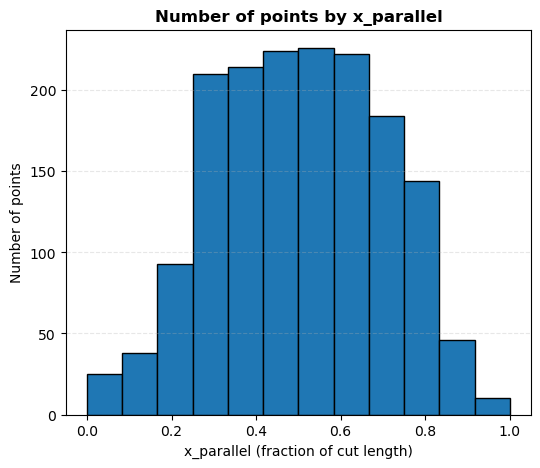

In [61]:
import benchmark.utils as bu

bu.plot_points_vs_x_parallel(points_cut, 12)

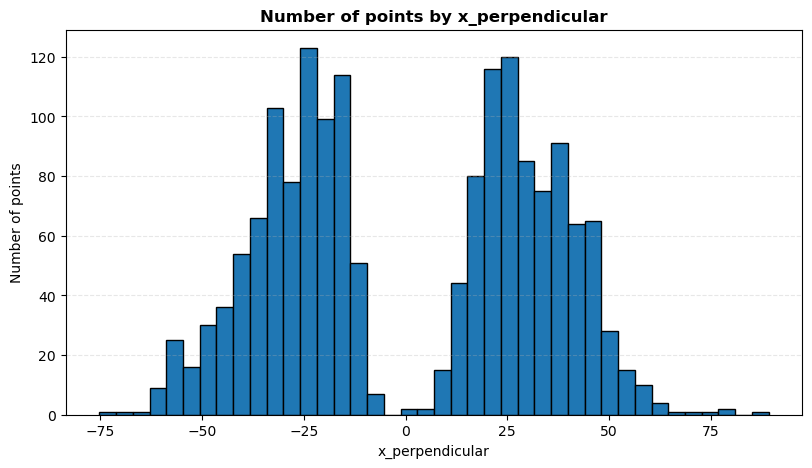

In [62]:
bu.plot_points_vs_x_perpendicular(points_cut, False, 40)

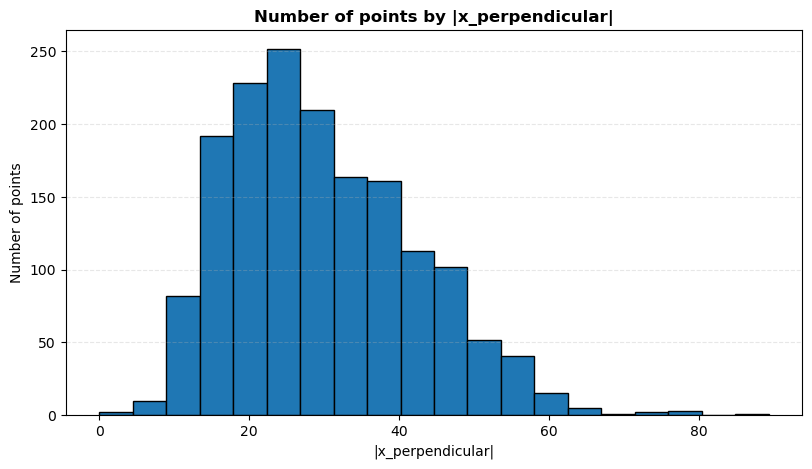

In [63]:
bu.plot_points_vs_x_perpendicular(points_cut, True, 20)

In [64]:
bu.animate_points_vs_x_perpendicular(points_cut, end_offset=8, abs=False)

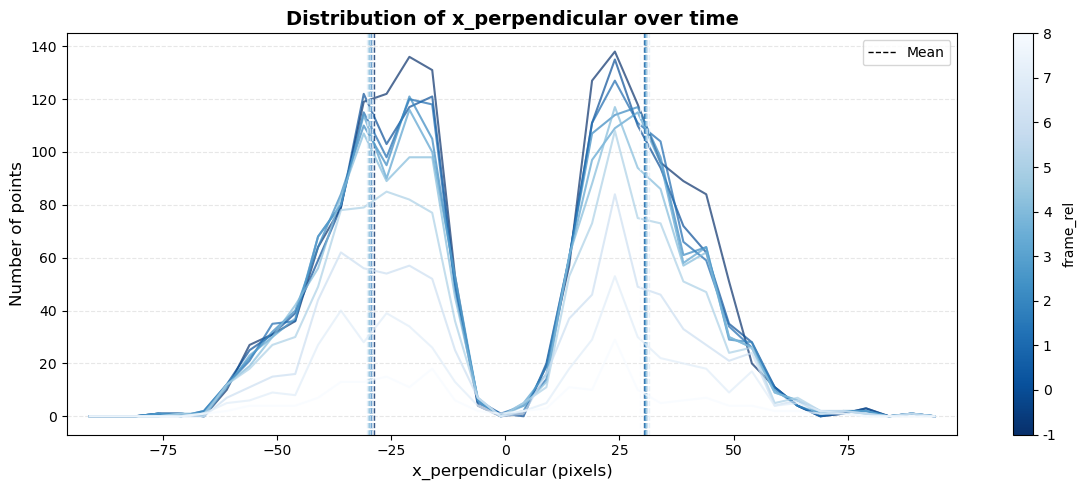

In [65]:
bu.plot_points_vs_x_perpendicular_overlapping(points_cut, end_offset=8, colormap='Blues_r', abs=False, bin_length=5)

In [66]:
bu.animate_points_vs_x_perpendicular(points_cut, True, end_offset=8)

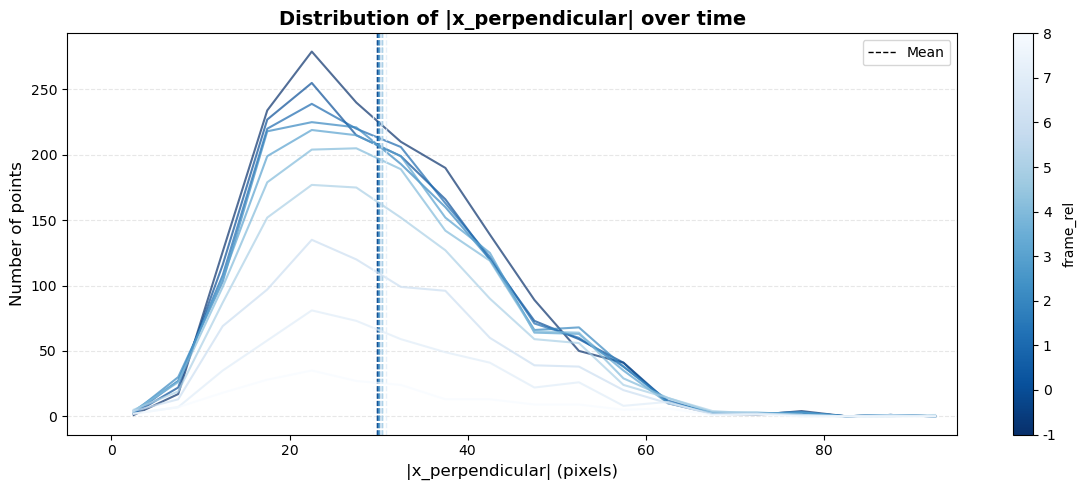

In [67]:
bu.plot_points_vs_x_perpendicular_overlapping(points_cut, end_offset=8, colormap='Blues_r', bin_length=5)

# Calculate time relative to first tracked point per cell and point velocities

In [68]:
import numpy as np

df = points_cut.copy()

# Compute velocity using frame as time reference, store on starting point
df = df.sort_values(["point_id", "frame"]).reset_index(drop=True)
df["dx"] = df.groupby("point_id")["x"].shift(-1) - df["x"]
df["dy"] = df.groupby("point_id")["y"].shift(-1) - df["y"]
df["dt"] = df.groupby("point_id")["frame"].shift(-1) - df["frame"]
df["vx"] = np.where(df["dt"] > 0, df["dx"] / df["dt"], np.nan)
df["vy"] = np.where(df["dt"] > 0, df["dy"] / df["dt"], np.nan)
df["velocity"] = np.sqrt(df["vx"]**2 + df["vy"]**2)

# Clean up intermediate columns
df = df.drop(columns=["dx", "dy"])

# Calculate cut velocities using frame as time reference, store on starting point
df["dx_parallel"] = df.groupby("point_id")["x_parallel"].shift(-1) - df["x_parallel"]
df["dx_perpendicular"] = df.groupby("point_id")["x_perpendicular"].shift(-1) - df["x_perpendicular"]
df["dt"] = df.groupby("point_id")["frame"].shift(-1) - df["frame"]
df["v_parallel"] = np.where(df["dt"] > 0, df["dx_parallel"] / df["dt"], np.nan)
df["v_perpendicular"] = np.where(df["dt"] > 0, df["dx_perpendicular"] / df["dt"], np.nan)
df["velocity_cut"] = np.sqrt(df["v_parallel"]**2 + df["v_perpendicular"]**2)

# Clean up intermediate columns
df = df.drop(columns=["dx_parallel", "dx_perpendicular", "dt"])

points_final = df.copy()

points_final.head()


,cell_id,point_id,frame,x,y,se,mse,cut,cut_time,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut
0,220530-E1_Out,0,3,368.000000,192.000000,NaN,84.378266,False,4,-1,0.781787,28.094557,93.434469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,220530-E1_Out,0,4,368.000000,192.000000,9.000000,84.378266,False,4,0,0.781787,28.094557,93.434469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,220530-E1_Out,0,5,368.000000,192.000000,17.000000,84.378266,False,4,1,0.781787,28.094557,93.434469,-1.025159,-0.179769,1.040802,0.000858,-1.037708,1.037709
3,220530-E1_Out,0,6,366.974841,191.820231,54.104253,84.378266,False,4,2,0.782645,27.056849,93.434469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,220530-E1_Out,0,7,366.974841,191.820231,69.154572,84.378266,False,4,3,0.782645,27.056849,93.434469,-0.096512,0.112095,0.147918,-0.001294,-0.085266,0.085276


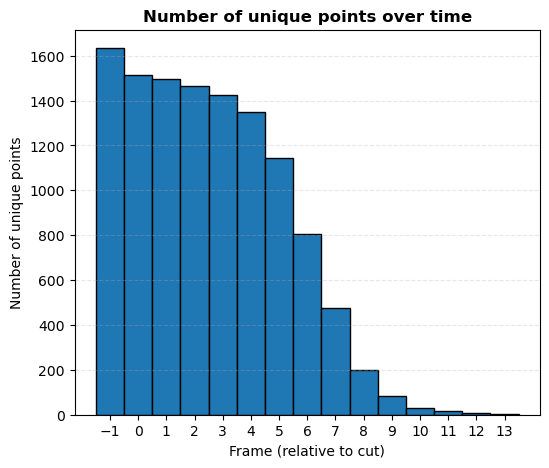

In [69]:
bu.plot_points_vs_frame(points_final[points_final['cut'] == False])

# Velocity analysis

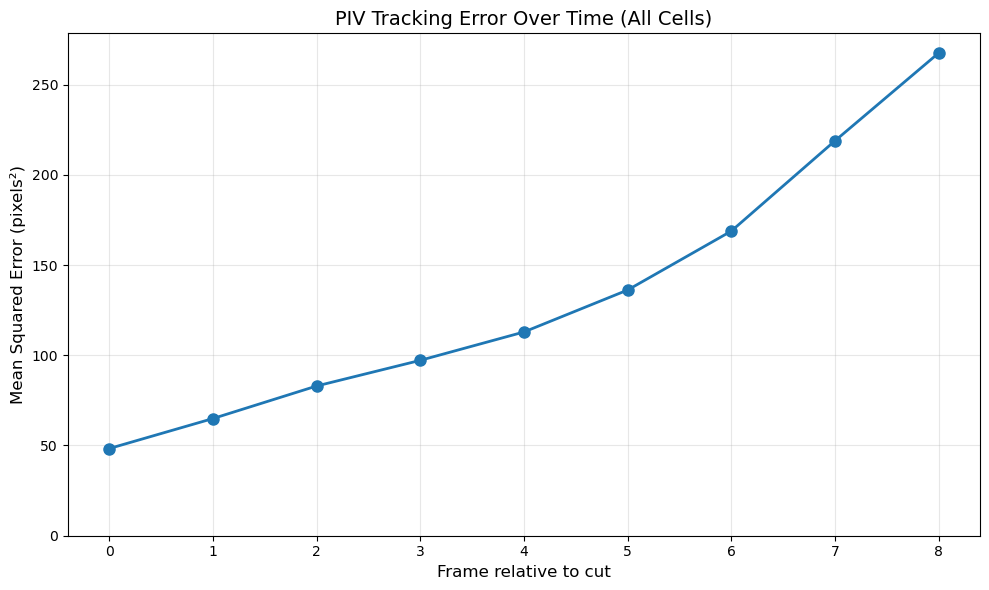

Overall MSE across all frames: 133.0607


In [78]:
# Plot MSE over time (frame_rel) averaged across all cells
import matplotlib.pyplot as plt

# Calculate mean SE per frame_rel (NaN values are automatically excluded)
df_for_plot = points_final[points_final['frame_rel'] >= -1][points_final['frame_rel'] <= 8].copy()
mse_per_frame_rel = df_for_plot.groupby('frame_rel')['se'].mean()

plt.figure(figsize=(10, 6))
plt.plot(mse_per_frame_rel.index, mse_per_frame_rel.values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Frame relative to cut', fontsize=12)
plt.ylabel('Mean Squared Error (pixels²)', fontsize=12)
plt.ylim(bottom=0)
plt.title('PIV Tracking Error Over Time (All Cells)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Overall MSE across all frames: {mse_per_frame_rel.mean():.4f}')

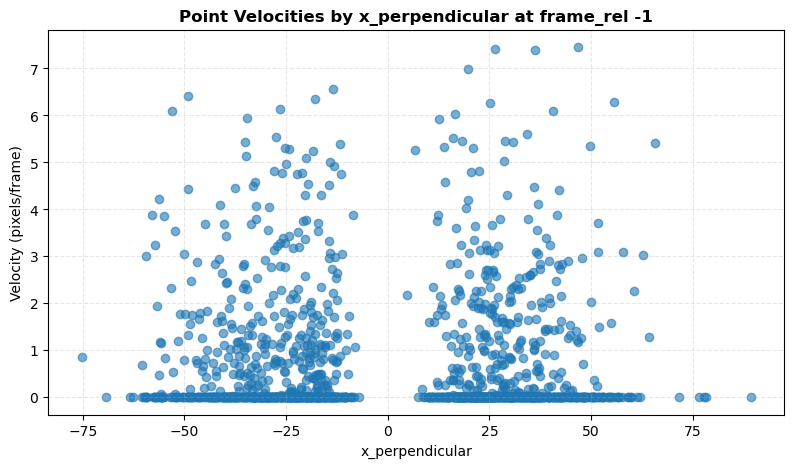

In [71]:
bu.plot_velocities_vs_x_perpendicular(points_final, False, frame_rel=-1)

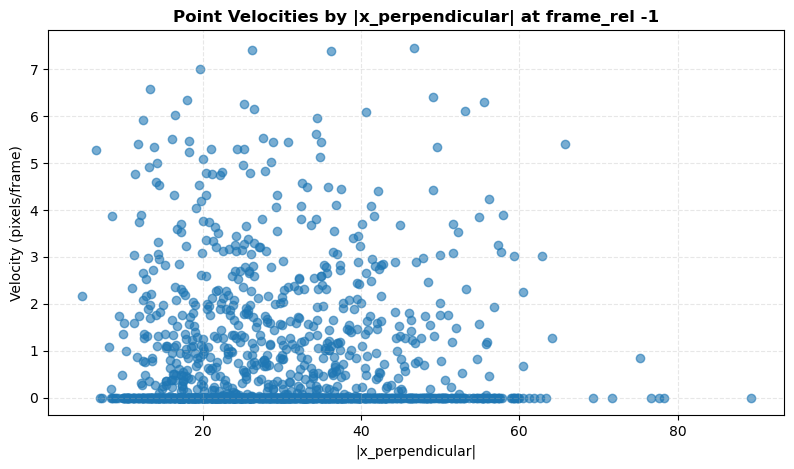

In [72]:
bu.plot_velocities_vs_x_perpendicular(points_final, frame_rel=-1)

In [73]:
# Filter for frame_rel == -1
df = points_final.copy()
subset = df[df['frame_rel'] == -1].dropna(subset=['velocity', 'x_perpendicular'])

# Calculate correlation between velocity and abs(x_perpendicular)
corr = subset['velocity'].corr(subset['x_perpendicular'].abs())
print(f"Correlation between velocity and abs(x_perpendicular) at frame_rel = -1: {corr:.3f}")

# p-value
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(subset['velocity'], subset['x_perpendicular'].abs())
print(f"P-value for the correlation: {p_value:.3e}")

Correlation between velocity and abs(x_perpendicular) at frame_rel = -1: -0.041
P-value for the correlation: 1.194e-01


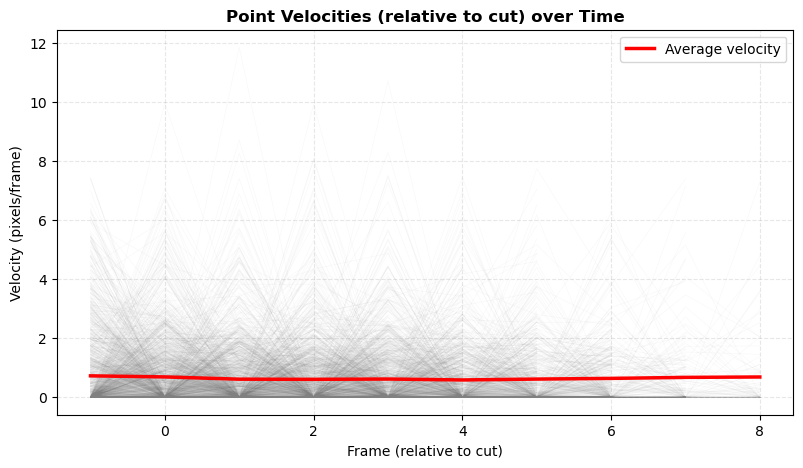

In [79]:
bu.plot_velocity_cut_vs_time(points_final, end_offset=8)

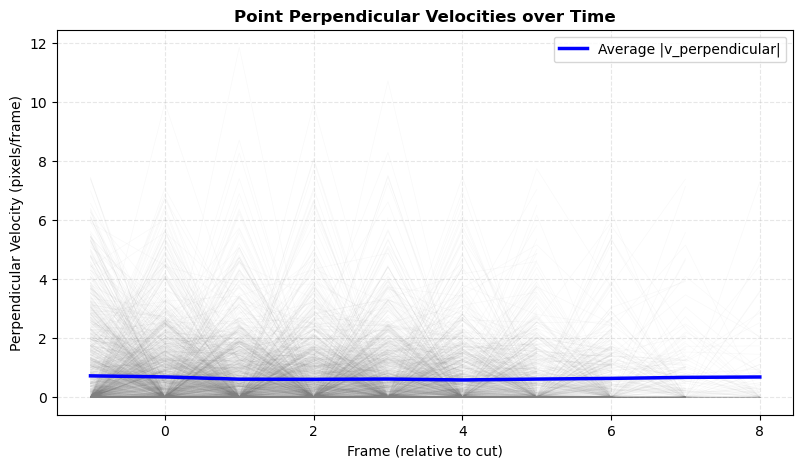

In [80]:
bu.plot_v_perpendicular_vs_time(points_final, end_offset=8)

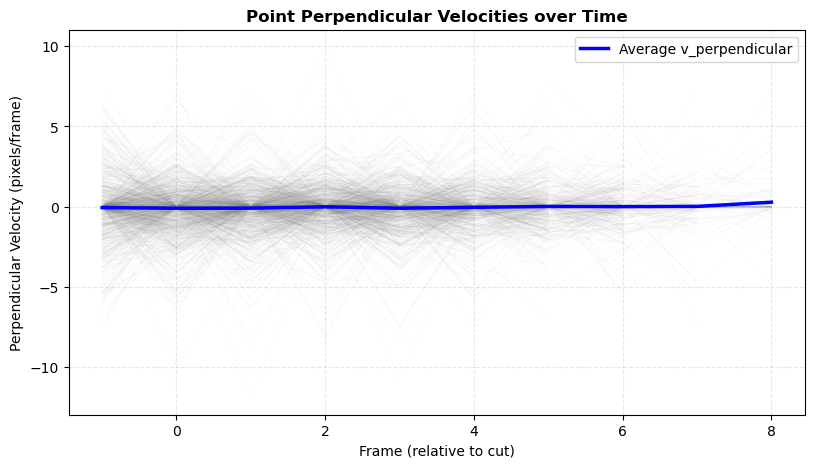

In [81]:
bu.plot_v_perpendicular_vs_time(points_final, abs=False, end_offset=8)

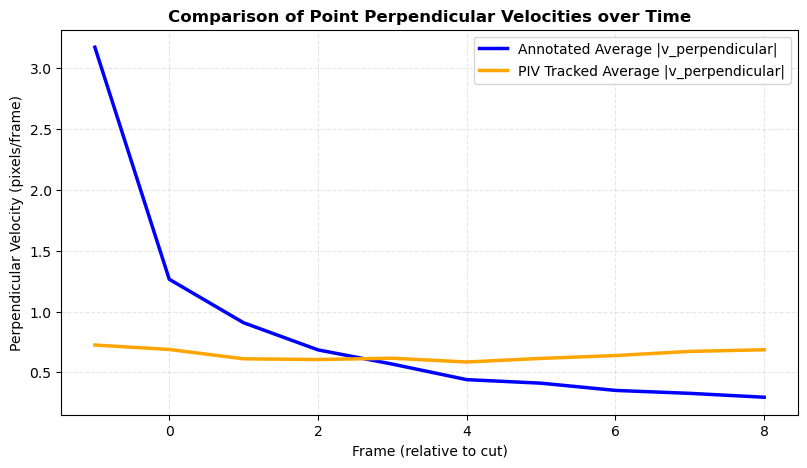

In [84]:
bu.compare_v_perpendicular_vs_time(annotated_df, points_final, label1='Annotated', label2='PIV Tracked', end_offset=8)